## Hueristic to improve preferred path for ancestor node
1. Date - 29 August 2022
2. Use in combination with extant based method

In [1]:
# libraries
from ete3 import Tree
from pysam import FastaFile
from scipy.spatial.distance import hamming
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

/Users/sanjanatule/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def sequence_distance_score(str1,str2):
    dis = 0
    prev_dis = 0
    
    str1 =  re.sub('[a-zA-Z]', 'a', str1)
    str2 =  re.sub('[a-zA-Z]', 'a', str2)
    
    for i in range(0,len(str1)):
        if str1[i] != str2[i]:  # not matching
            if prev_dis == 0:   # previous unmatched
                dis += 3
                prev_dis = 1
            else:
                dis += 1
        else:
            prev_dis = 0
    return dis

print(sequence_distance_score('AAAAAAA','AAAAAAA'))
print(sequence_distance_score('_AAAAAA','AAAAAAA'))
print(sequence_distance_score('AAA__AA','AAAAAAA'))
print(sequence_distance_score('AA_A_AA','AAAAAAA'))


0
3
4
6


In [3]:
def convert_sequence_to_array(str1):
    
    # add 'a' at the start and end of the string
    str1 = 's' + str1 + 'e'
    print('str1',str1)
    
     # empty array
    m = np.zeros((len(str1),len(str1)))
   
    ptr = 0
    for i in range(1,len(str1)):
        print("str1[i]",str1[i])
        if str1[i] != '-':
            m[ptr][i] = 1
            ptr = i
              
    print(m)
    
    
convert_sequence_to_array('a-a--aa--')

str1 sa-a--aa--e
str1[i] a
str1[i] -
str1[i] a
str1[i] -
str1[i] -
str1[i] a
str1[i] a
str1[i] -
str1[i] -
str1[i] e
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [8]:
# class - to load tree, load sequences, neighbours, pogs, hamming distance, overall score for a given tree.

class PhyloTree:
    
    def __init__(self,nwk_file_path,ancestor_fasta_file,json_pogs_file):
        ''' initialise the PhyloTree Class '''
        tree_file = open(nwk_file_path,"r")
        my_tree = tree_file.read() + ";"
        self.tree = Tree(my_tree, format=1)
        self.iterations = 1
        self.all_ancestor_nodes = []
        self.all_ancestor_pogs_path = []
        self.ancestor_fasta_file = ancestor_fasta_file
        self.json_pogs_file = json_pogs_file
        self.folder_to_save_numpy_arrays = '/'.join(self.json_pogs_file.split('/')[0:-1]) + '/'
        self.total_tree_score = 0
        self.nodes_changed_details = []
        # track for score and nodes improved
        self.score_track    = []
        self.nodes_improved = []
        self.summary = []
               
        
    def sequence_distance_score(self,str1,str2):
        ''' 2 sequence scoring formula '''
        
        # ignore amino acids
        str1 =  re.sub('[a-zA-Z]', 'a', str1)
        str2 =  re.sub('[a-zA-Z]', 'a', str2)
          
        dis = 0
        prev_dis = 0

        for i in range(0,len(str1)):
            if str1[i] != str2[i]:  # not matching
                if prev_dis == 0:   # previous unmatched
                    dis += 3
                    prev_dis = 1
                else:
                    dis += 1
            else:
                prev_dis = 0
        return dis
          
    def load_attributes(self):
        ''' load node attributes - sequences, neighbours, hamming distance '''
        sequences_info = FastaFile(self.ancestor_fasta_file)
        
        for n in self.tree.traverse():
            
            ancestor_nodes_info = {}
            current_node_sequence = sequences_info.fetch(n.name)
            sequence_simple       = re.sub('[a-zA-Z]', 'a', sequences_info.fetch(n.name))
            neighbor_n_distance = {}
            child_n_distance = {}
                
            if n.is_leaf() == False:    
                # add node sequence on the tree    
                
                for c in n.children:
                    child_sequence = sequences_info.fetch(c.name)
                    distance_calc = self.sequence_distance_score(current_node_sequence,child_sequence)
                    neighbor_n_distance[c.name] = distance_calc
                    child_n_distance[c.name]    = distance_calc
                    
                if n.is_root() == False:
                    parent_sequence = sequences_info.fetch(n.up.name)
                    neighbor_n_distance[n.up.name] = self.sequence_distance_score(current_node_sequence,parent_sequence)
                    
            
            # assemble all information into 1 dictionary
            ancestor_nodes_info['name'] = n.name
            ancestor_nodes_info['sequence'] = sequence_simple
            ancestor_nodes_info['neighbor_n_distance'] = neighbor_n_distance
            ancestor_nodes_info['child_n_distance'] = child_n_distance
            self.all_ancestor_nodes.append(ancestor_nodes_info)
            
        #print(self.all_ancestor_nodes)
        
                
    def count_path(self,a):
        ''' count the number of paths in a graph '''
        a = a + a.T    #add up the transpose
        a = np.clip(a,0,1)
        a = np.triu(a) #only the upper triangle

        nodes = a.shape[0]
        dp = [0] * nodes
        dp[nodes - 1]= 1 #last node

        for i in range(nodes - 1, -1, -1):
            neighbour_nodes = np.where (a[i] == 1)[0]
            for j in neighbour_nodes:
                dp[i] = dp[i] + dp[j]

        return(dp[0])
        
    
    def paths_in_pogs_cnt(self):
        ''' total paths in the pogs for ancestor nodes '''
        ''' save pogs as numpy array '''
        
        total_sequences_list = []
        all_exp_results = []
        
        # read the json file
        with open(self.json_pogs_file, 'r') as j:
            pog_all_data = json.loads(j.read())

            # read all ancestors
            for node_type in ['Ancestors','Extants']:
                for pog_data in pog_all_data[node_type]:
                    
                    pog_path_dict = {}
                    
                    if node_type == 'Ancestors':
                        node_name = 'N' + pog_data['Name']
                    else:
                        node_name = pog_data['Name']
                    
                    pog_path_dict['name'] = node_name

                    # read that node's data
                    nodes = pog_data['Size'] + 2

                    # create numpy zero matrix
                    mat = np.zeros(shape=(nodes,nodes))

                    # Edges from special Start node to the start nodes
                    for s in pog_data['Starts']:
                        mat[0,s + 1] = 1

                    # Edges from last node to the special End node
                    for e in pog_data['Ends']:
                        mat[e + 1,nodes-1] = 1

                    # create the adjency matrix for all nodes except from special node start
                    for ind,node in enumerate(pog_data['Indices']):
                        row_mat = node
                        row_col = pog_data['Adjacent'][ind]

                        for rc in row_col:
                            mat[row_mat + 1,rc + 1] = 1
                        

                    # count the number of viable paths from the POG
                    total_sequences = self.count_path(mat)

                    pog_path_dict['total_paths'] = total_sequences

                    self.all_ancestor_pogs_path.append(pog_path_dict)

                    # save pogs as numpy array ( needed later for markov chain hueristic)

                    # convert bidirectional mat into unidirectional
                    mat = mat + mat.T     #add up the transpose
                    mat = np.clip(mat,0,1)
                    mat = np.triu(mat)   #only the upper triangle
                    
                    # save numpy array in file
                    mat_file_name = self.folder_to_save_numpy_arrays +  node_name + '.npy'
                    np.save(mat_file_name,mat)
      
    
    def convert_sequence_to_array(self,str1):
        ''' convert sequence into numpy array as a pog'''
    
        # add 'a' at the start and end of the string
        str1 = 's' + str1 + 'e'

         # empty array
        m = np.zeros((len(str1),len(str1)))

        ptr = 0
        for i in range(1,len(str1)):
            if str1[i] != '-':
                m[ptr][i] = 1
                ptr = i

        return m
    
        
    def weighted_nodes_model(self,node_to_improve,neighbor_list,use_pog):
        ''' weighted model to find preferred path for a ancestor node.
            Each position in the sequence is a state in the markov chain model.'''
        
        total_states   = np.load(self.folder_to_save_numpy_arrays + neighbor_list[0] + '.npy').shape[0]    
        wt_model       = np.full((total_states, total_states),0)   
        
        # sum up the neighbor pog/sequence depending on parameter
        for n in neighbor_list:
            if use_pog == 1:
                m = np.load(self.folder_to_save_numpy_arrays + n + '.npy')
            else:
                n_sequence = self.combined_df[self.combined_df['name'] == n]['sequence'].to_string(index=False)
                m = self.convert_sequence_to_array(n_sequence)
                
            wt_model = np.add(wt_model,m)

        #print("All Neighbor POG")
        #print("wt_model",wt_model)
        #self.translateModel(wt_model,0)
            
        # project the neighbour markov chain into the current node
        # if the path does not exists in the current node, change the value to 0
        current_node_np = np.load(self.folder_to_save_numpy_arrays + node_to_improve + '.npy')
        
        # node not present will be wiped out
        wt_model = wt_model * current_node_np
        
        # add the current node pog
        wt_model = wt_model + current_node_np
        
        #print(self.translateModel(wt_model,0))
        
        # normalise the weights
        wt_model = wt_model / (len(neighbor_list) + 1)  # add 1 as current node is also considered
        
        
        # wherever it is 0, put a max weight, to avoid divide by 0 error
        wt_model[wt_model == 0] = -9999
        
        # -log(weight) transformation
        wt_model = -1 * np.log10(wt_model, out = wt_model, where = wt_model > -9999)
        
        return wt_model
    
    
    def translateModel(self,wt_model,value_skip):
        ''' function to translate the model for human readable format'''
        
        total_nodes = wt_model.shape[0]
        
        for i in range(0,total_nodes):
            for j in range(0,total_nodes):
                if wt_model[i][j] != value_skip:
                    print("Distance from node {} to node {} is. {}".format(i,j,wt_model[i][j]))
        
    
    def minDistance(self,dist,sptSet,total_nodes):
        
        # Initialize minimum distance for next node
        min = 1e7
        
        # Search not nearest vertex not in the
        # shortest path tree
        for v in range(total_nodes):
            if dist[v] <= min and sptSet[v] == False:
                min = dist[v]
                min_index = v

        return min_index
    
    def djikstra_shortest_path(self,wg_model):
        
        total_nodes = wg_model.shape[0] # total nodes to traverse
        dist = [1e7] * total_nodes
        dist[0] = 0
        sptSet   = [False] * total_nodes
        previous = [False] * total_nodes
        previous[0] = 0
        
        for cout in range(total_nodes):
            u = self.minDistance(dist, sptSet,total_nodes)
            sptSet[u] = True
            for v in range(total_nodes):
                if (wg_model[u][v] != 9999 and sptSet[v] == False and 
                dist[v] > dist[u] + wg_model[u][v]):
                    dist[v] = dist[u] + wg_model[u][v]
                    previous[v] = u
        
        
        
        #print('previous',previous)
        # find shortest path
        pf    = [0] * total_nodes       # preferred path
        pf[0] = 1                       # starting node is always traversed
        
        # start from last node and go backwards
        target = len(previous)-1
        last_node = target
        pf[last_node] = 1  
        
        while(last_node!=0):
            last_node = previous[last_node]
            pf[last_node] = 1
        
        pf = pf [1:-1] # return path except for the first and last path
        return pf

    
    def calculate_score(self,mc_output,node_to_improve,neighbor_list,current_score):
        
        # replace 1 by a and 0 by - for hamming distance calculation
        #print('mc_output',mc_output)
        mc_output_sequence = ['a' if item == 1 else '-' for item in mc_output] 
        mc_output_sequence = ''.join(mc_output_sequence)
        
        # current node row
        node_df_info           = self.combined_df[self.combined_df['name'] == node_to_improve]
        current_indel_distance = float(node_df_info['avg_indel_distance'].to_string(index=False))
        current_sequence       = node_df_info['sequence'].to_string(index=False)
        
        # recalculate current node avg indel distance w.r.t neighbors
        node_avg_indel_distance  = 0
        node_child_n_distance    = {}
        node_neighbor_n_distance = {}
            
        for n in neighbor_list: 
            neighbor_sequence = self.combined_df[self.combined_df['name'] == \
                                              n]['sequence'].to_string(index=False)
            distance_calc = self.sequence_distance_score(mc_output_sequence,neighbor_sequence)
            node_avg_indel_distance += distance_calc
            node_neighbor_n_distance[n]  = distance_calc
            
            # check if present in child
            if n in node_df_info['child_n_distance'].values[0]:
                node_child_n_distance[n] = distance_calc
            
        node_avg_indel_distance = node_avg_indel_distance / len(neighbor_list) 
        
        print("BEFORE AVERAGE INDEL DISTANCE::",current_indel_distance)
        print("NEW AVERAGE INDEL DISTANCE::"   ,node_avg_indel_distance)
            
        # compare the scores
        if round(node_avg_indel_distance,4) < round(current_indel_distance,4): # recalculate neigh distance again
            
            print('NEW INDEL DISTANCE IS LESS THAN THE CURRENT INDEL DISTANCE')
            
            #print("BEFORE SEQUENCE:",current_sequence)
            #print("AFTER SEQUENCE:" ,mc_output_sequence)
            
            if self.sequence_distance_score(current_sequence,mc_output_sequence) == 0:
                print("ERROR:: BEFORE AND AFTER SEQUENCE ARE THE SAME.")
            
            # update the new sequence for the node
            self.combined_df.loc[self.combined_df['name'] == node_to_improve,'sequence']\
                                        = mc_output_sequence
            self.combined_df.loc[self.combined_df['name'] == node_to_improve,'neighbor_n_distance']\
                                            = [node_neighbor_n_distance]
            self.combined_df.loc[self.combined_df['name'] == node_to_improve,'child_n_distance']\
                                            = [node_child_n_distance]

            # update the neighboring node information in dataframe
            for n in neighbor_list:
                n_neighbor_n_distance = self.combined_df[self.combined_df['name'] == n]\
                                            ['neighbor_n_distance'].values[0]
                
                # check if present in the neighbor
                if node_to_improve in n_neighbor_n_distance:
                    n_neighbor_n_distance[node_to_improve] = node_neighbor_n_distance[n]
                    self.combined_df.loc[self.combined_df['name'] == n,'neighbor_n_distance']\
                                                = [n_neighbor_n_distance]     

                # check if present in child
                n_child_n_distance = self.combined_df[self.combined_df['name'] == n]\
                                            ['child_n_distance'].values[0]
                if node_to_improve in n_child_n_distance:
                    n_child_n_distance[node_to_improve] = node_neighbor_n_distance[n]
                    self.combined_df.loc[self.combined_df['name'] == n,'child_n_distance']\
                                            = [n_child_n_distance]
                
            
            # rerun the distance calculation again
            self.score_nodes()
            
            # new score
            score = self.combined_df['total_child_distance'].sum()
            score_improve_flag = 1
            
            # store the changes made, so can be used for visualisation
            
            node_change_detailed_tuple = self.position_diff(current_sequence,mc_output_sequence,node_to_improve)
            self.nodes_changed_details.append(node_change_detailed_tuple)
            
        else:
            score = current_score
            score_improve_flag = 0
        
        # marked node as visited
        self.combined_df.loc[self.combined_df['name'] == node_to_improve, 'visited'] = True
            
        return score,score_improve_flag
        
    
    def position_diff(self,str1,str2,node_to_improve):
        ''' position by psoition differece'''
        
        ret_tuple = [node_to_improve]
        # ignore amino acids
        str1 =  re.sub('[a-zA-Z]', 'a', str1)
        str2 =  re.sub('[a-zA-Z]', 'a', str2)
         

        for i in range(0,len(str1)):
            if str1[i] != str2[i]:  # not matching
                if str1[i] == 'a':
                    ret_tuple.append(-1)  # deletion
                else:
                    ret_tuple.append(1)  # insertion
            else:
                ret_tuple.append(0)
                
        return tuple(ret_tuple)
        
    
    def neighbor_optimise(self,node_to_improve,neighbor_list,current_score,method):
        ''' use neighbor pog for preferred path '''       
        
        # DJIKSTRA MODEL - GRASP PAPER
        if method == 'pog':
            wg_model  = self.weighted_nodes_model(node_to_improve,neighbor_list,use_pog=1)
        elif method == 'sequence':
            wg_model  = self.weighted_nodes_model(node_to_improve,neighbor_list,use_pog=0)
 
        # perform inference
        wg_output = self.djikstra_shortest_path(wg_model)

        # evaluate score
        new_score,score_improve_flag = self.calculate_score(wg_output,node_to_improve,neighbor_list,current_score)
        
        return score_improve_flag,new_score
            
    
    def score_visual(self,score_history):
        ''' visualise score improvement '''
        
        for s in score_history:
            plt.plot(*zip(*s[1]))
            plt.title('SCORE IMPROVEMENT HISTORY FOR METHOD' + str(s[0]))
            plt.xlabel('ITERATION')
            plt.ylabel('TREE - INDEL PARSIMONY SCORE')
            plt.show()
        
    
    def visualise_changed_nodes(self):
        
        if len(self.nodes_changed_details) > 0 :
            sns.set(rc = {'figure.figsize':(50,20)})

            # Create an array with the colors you want to use
            colors = ["#FF0000", "#F5F5F5","#00FF00"]
            total_nodes = len(self.nodes_changed_details[0]) - 1
            columns_df = ['Node'] + list(range(1,total_nodes+1))
            amino_acid_pd = pd.DataFrame(self.nodes_changed_details,columns = columns_df)
            display(amino_acid_pd.head())
            amino_acid_pd.set_index('Node',inplace=True)

            ax = sns.heatmap(amino_acid_pd,center=0,vmin = -1, vmax = 1, cmap=colors)
            colorbar = ax.collections[0].colorbar
            colorbar.set_ticks([-0.75,0,0.75])
            colorbar.set_ticklabels(['DELETE','SAME','INSERT'])
        else:
            print("NO NODES CHANGED")
         
    def sum_dict_values(self,d):
        if len(d) != 0:
            return sum(dict(d).values())/(len(dict(d)))
        else:
            return 0

    def score_nodes(self):
        ''' calculate the avg indel distance and total child distance '''
        self.combined_df['avg_indel_distance']   =  self.combined_df['neighbor_n_distance'].\
                                                                apply(self.sum_dict_values)
        self.combined_df['total_child_distance'] =  self.combined_df['child_n_distance'].\
                                                    apply(lambda x: sum(dict(x).values()))
                
            
    def hueristic_method(self,method):
        ''' different huersitic methods'''
        
        method_score = []
        # 2.1 - add nodes with only 1 path in the visited nodes list
        self.combined_df['visited'] = 0
        self.combined_df['visited'] = self.combined_df['total_paths'] == 1

        # 2.2 - mark all nodes as not improved
        self.combined_df['improved'] = 0

        # 2.3 - calculate avg indel distance and neighbor distance
        self.score_nodes()
        
        #print(self.combined_df)

        # 2.4 - add rank for the nodes based on distance from neighbors
        self.combined_df['rank_pathcnts'] = self.combined_df['total_paths'].rank()
        self.combined_df['rank_distance'] = self.combined_df['avg_indel_distance'].rank()
        self.combined_df['total_rank']    = self.combined_df['rank_distance'] + self.combined_df['rank_pathcnts'] 
        pd.set_option('display.max_colwidth', None)

        # 3 - parameters for hueristic
        total_nodes_to_improve = sum(self.combined_df['visited'] == False)
        score_not_improve_cnt  = 0

        self.summary.append(total_nodes_to_improve)
        
        current_score = self.combined_df['total_child_distance'].sum()
        method_score.append((0,current_score))
        print("TOTAL POTENTIAL NODES FOR IMPROVEMENT::",total_nodes_to_improve)
        
        # 4 - loop
        for i in range(1,total_nodes_to_improve + 1):

            print("NODE IMPROVEMENT::",i)
            current_score = self.combined_df['total_child_distance'].sum()
            print("CURRENT SCORE::", current_score)

            # pick node with max rank and which has not been visited
            df_filtered = self.combined_df[self.combined_df['visited'] == False].reset_index()    
            max_df_row  = df_filtered.iloc[df_filtered['total_rank'].idxmax()]
            node_to_improve = max_df_row['name']            
            node_neighbors = self.combined_df[self.combined_df['name'] == \
                                            node_to_improve]['neighbor_n_distance'].\
                                            apply(lambda x: list(dict(x).keys())).values[0]
            print("NODE SELECTED FOR IMPROVEMENT::",node_to_improve)
            print('NEIGHBOURS::',node_neighbors)

            # improve indel score here by choosing alternate path
            score_improve_flag,new_score = self.neighbor_optimise(node_to_improve,node_neighbors,current_score,method)

            if score_improve_flag == 1:
                print("SCORE IMPROVED FROM:{} TO {}".format(current_score,new_score))
                # update node as improved
                self.combined_df.loc[self.combined_df['name']== node_to_improve,'improved'] = 1
                # track nodes
                self.nodes_improved.append(node_to_improve)

            else:
                print("SCORE DID NOT IMPROVE")
                score_not_improve_cnt += 1 # update the consecutive score improvement

            # track score
            method_score.append((i,new_score))
            
        print("NUMBER OF NODES IMPRVED::",sum(self.combined_df['improved']))
        print("NODES IMPRVED::",self.nodes_improved)
        return method_score
        
    
    def hueristic_preferred_path(self):
        ''' hueristic algorithm to improve the overall tree score by selecting alternative preferred path '''
        
        start = time.time()
        
        # 1 - create a combined dataframe
        self.combined_df = pd.merge(pd.DataFrame(self.all_ancestor_nodes),\
                                pd.DataFrame(self.all_ancestor_pogs_path),how='left')

        ########## 2 - improve using POGs ########## 
        print("################HUERISTICS USING POGs################")
        score_history = self.hueristic_method(method = 'pog')
        self.score_track.append(('pog',score_history))
        
        print("################HUERISTICS USING SEQUENCE############")
        score_history = self.hueristic_method(method = 'sequence')
        self.score_track.append(('sequence',score_history))
        print("OVERALL SCORE TRACKER::",self.score_track)
        
        end = time.time()
        
        
        self.summary.append(self.score_track[0][1][1][1])
        self.summary.append(self.score_track[1][1][-1][1])
        self.summary.append(len(self.nodes_improved))
        self.summary.append(end - start)
        
        print("********* FINISHED ************")
        print("TOTAL TIME TO RUN::",end - start)
        print("OVERALL NODES IMPRVED::",self.nodes_improved)
        print("OVERALL SCORE TRACKER::",self.score_track)
        print("OVERALL SUMMARY::",self.summary)
        
        return self.score_track,self.combined_df       

In [5]:
# Different trees to test the algorithm

# ## sample toy tree
# nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/sample_tree/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/sample_tree/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/sample_tree/pogs.json'

## CYP2U - 165
# nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_165/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_165/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_165/pogs.json'

# ## CYP2U - 359
# nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_359/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_359/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_359/pogs.json'

# ## CYP2U - 595
# nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_595/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_595/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_595/pogs.json'

# ## DHAD - 585
# nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/DHAD_585/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/DHAD_585/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/DHAD_585/pogs.json'

# ## DHAD - 1612
# nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/DHAD_1612/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/DHAD_1612/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/DHAD_1612/pogs.json'

# ## KARI - 1176
# nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/KARI_1176/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/KARI_1176/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/KARI_1176/pogs.json'

# ## GO - 399
# nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/GDH-GOx_399/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/GDH-GOx_399/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/GDH-GOx_399/pogs.json'

## sample tree 3
nwk_file_path = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/st3/grasp_ancestors.nwk'
ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/st3/grasp_ancestors.fa"
pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/st3/pogs.json'


## sample tree 5
# nwk_file_path = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/st5/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/st5/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/st5/pogs.json'

# hueristic steps
asrtree = PhyloTree(nwk_file_path,ancestor_fasta_file,pogs_file)
asrtree.load_attributes ()
asrtree.paths_in_pogs_cnt()
score_history,nodes_info_df = asrtree.hueristic_preferred_path()

################HUERISTICS USING POGs################
   name         sequence           neighbor_n_distance     child_n_distance  \
0    N0  aaa--aa-a-a-aaa            {'A4': 8, 'N1': 0}   {'A4': 8, 'N1': 0}   
1    A4  aaaaaaa-a-aa-aa                            {}                   {}   
2    N1  aaa--aa-a-a-aaa   {'N2': 3, 'N5': 0, 'N0': 0}   {'N2': 3, 'N5': 0}   
3    N2  aa---aa-a-a-aaa   {'N3': 0, 'A1': 3, 'N1': 3}   {'N3': 0, 'A1': 3}   
4    N5  aaa--aa-a-a-aaa  {'A10': 0, 'N6': 0, 'N1': 0}  {'A10': 0, 'N6': 0}   
5    N3  aa---aa-a-a-aaa   {'A5': 3, 'N4': 0, 'N2': 0}   {'A5': 3, 'N4': 0}   
6    A1  aa---aa-a---aaa                            {}                   {}   
7   A10  aaa--aa-a-a-aaa                            {}                   {}   
8    N6  aaa--aa-a-a-aaa   {'N7': 0, 'N8': 0, 'N5': 0}   {'N7': 0, 'N8': 0}   
9    A5  aa----a-a-a-aaa                            {}                   {}   
10   N4  aa---aa-a-a-aaa  {'A2': 12, 'A6': 0, 'N3': 0}  {'A2': 12, 'A6': 0}  

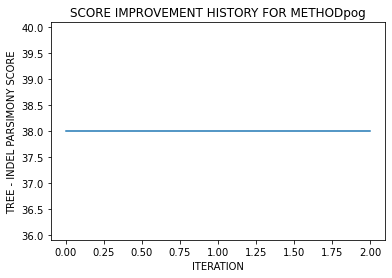

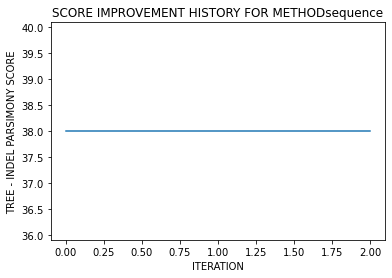

In [6]:
asrtree.score_visual(score_history)

In [7]:
asrtree.visualise_changed_nodes()

NO NODES CHANGED
